# Exercício 1

Consider a database and a classification problem. Apply leave-one-out multi-fold cross-validation explained in section 8.5 of [4], with K = 4, for a MLP model. Use the facilities available in libraries for neural network implementation, like Keras, Tensor flow, scikit-learn, Matlab, etc. [7].
OBS: For image databases, convert each image to grayscale and use the image histogram for feature
extraction.

(a) Show the graphical representation of the evolution of training and validation stages (see Figure
8.8 of the course monograph).

(b) Perform a statistical analysis of the performance (section 8.6) of the four models applied over
the Dte.

(c) Analyze the influence of optimizer hyperparameters

### Importando dados

Vamos importar o dataset fashions_mnist do keras que é um dataset composto de 70.000 imagens em tons de cinza de 28x28 pixels classificadas em 10 classes. Essas imagens são compostas por: \
0	camiseta\
1	calça\
2	suéter\
3	vestido\
4	casaco\
5	sandália\
6	camisa\
7	tênis\
8	bolsa\
9	bota cano curto

In [27]:
from keras.datasets import fashion_mnist
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import cv2
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [28]:
# carrega o dataset MNIST
(x1, y1), (x2, y2) = fashion_mnist.load_data()

# concatena todos os dados que vem separados
x_all = np.concatenate((x1, x2,), axis=0)
y_all = np.concatenate((y1, y2), axis=0)

Plotando imagem exemplo:

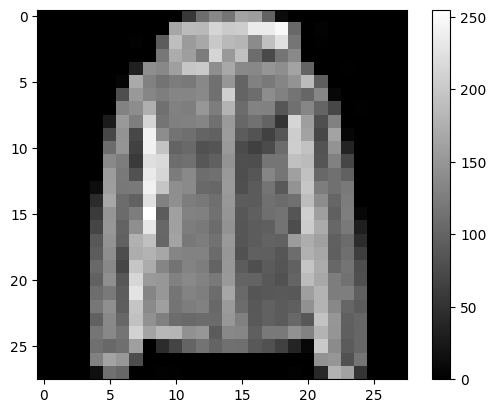

(70000, 28, 28)


In [29]:
plt.figure()
plt.imshow(x_all[4538], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
print(x_all.shape)

# Fazendo modelo para extração de features por histograma de frequências

Fazendo histograma de cinzas para todas as imagens do conjunto:

In [30]:
def calcular_histograma(imagem):
    # Calcula o histograma de uma imagem em tons de cinza
    histograma = cv2.calcHist([imagem], [0], None, [256], [0, 256])
    histograma = histograma.flatten()

    return histograma

def transformar_banco_de_dados(banco_de_dados):
    vetores_histograma = []
    
    for imagem in banco_de_dados:
        
        histograma = calcular_histograma(imagem)
        vetores_histograma.append(histograma)
    
    return np.array(vetores_histograma)


x = transformar_banco_de_dados(x_all)

print(x.shape)

(70000, 256)


In [31]:
x


array([[351.,  11.,   2., ...,   0.,   0.,   4.],
       [297.,  14.,   7., ...,   1.,   2.,   6.],
       [455.,   2.,   1., ...,   0.,   0.,   1.],
       ...,
       [509.,   9.,   4., ...,   0.,   0.,   2.],
       [574.,   2.,   0., ...,   0.,   0.,   2.],
       [420.,  29.,  10., ...,   0.,   1.,   0.]], dtype=float32)

Plotando histograma de exemplo:

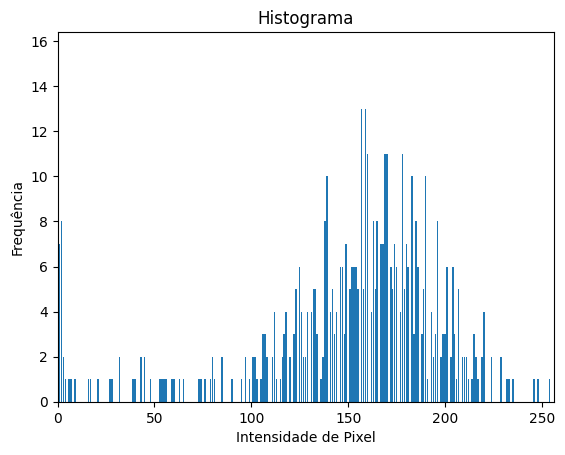

In [32]:
plt.figure()
plt.title("Histograma")
plt.xlabel("Intensidade de Pixel")
plt.ylabel("Frequência")
plt.bar(range(len(x[255])), x[255])
plt.xlim([0, 256])
plt.ylim([0, max(x[256])*0.05])
plt.show()

Dividindo conjunto de dados em treino/validação e teste:

In [33]:
x, x_test, y, y_test = train_test_split(
    x, y_all, test_size=0.2, random_state=42
)

Exibindo o histograma sobre o número de cada tipo de imagem:

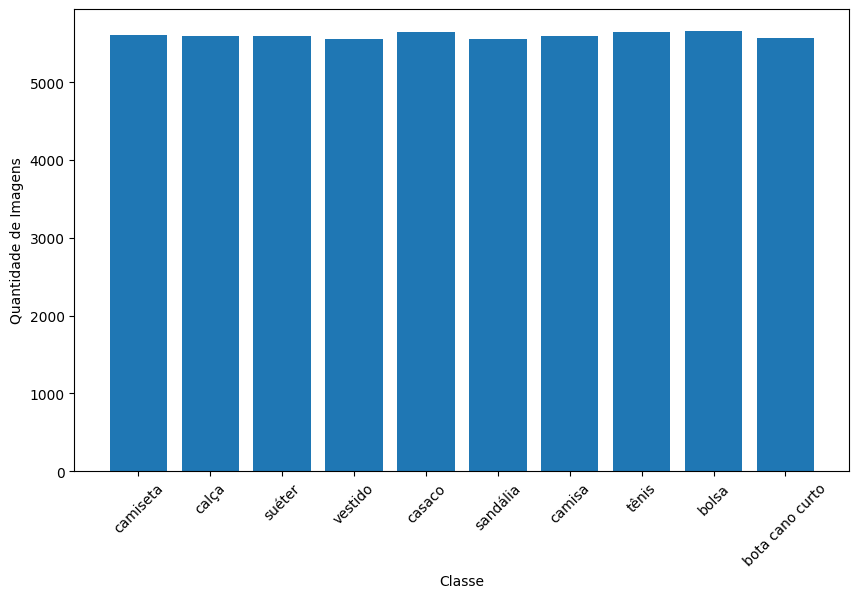

In [34]:
# Conta a quantidade de imagens para cada classe no conjunto de treinamento
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plotar o histograma
class_names = ['camiseta', 'calça', 'suéter', 'vestido', 'casaco', 'sandália', 'camisa', 'tênis', 'bolsa', 'bota cano curto']

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), tick_label=class_names)
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
#plt.title('Quantidade de Imagens por Classe no Conjunto de Treinamento Fashion')
plt.xticks(rotation=45)
plt.show()


Fazendo um modelo inicial para analisar a influência dos hiperparâmetros do otimizador e fazer a melhor escolha através de um grid search:

In [ ]:
def criar_modelo(optimizer='adam', learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False):
    model = Sequential()
    model.add(Dense(128, input_dim=256, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dense(10, activation='softmax'))

    # Configurando modelo
    if optimizer == 'adam':
        optimizer = Adam(
            learning_rate=learning_rate,
            beta_1=beta_1,
            beta_2=beta_2,
            epsilon=epsilon,
            amsgrad=amsgrad
        )
    else:
        raise ValueError("O otimizador fornecido não é suportado")

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=criar_modelo, verbose=0)

# grade de parametros para a busca
param_grid = {
    'batch_size': [32,64,128,256],
    'epochs': [20,30,40,50,100],
    'optimizer__learning_rate': [0.001, 0.01],
    'optimizer__beta_1': [0.9, 0.95],
    'optimizer__beta_2': [0.999, 0.9999],
    'optimizer__epsilon': [1e-7, 1e-8],
    'optimizer__amsgrad': [False, True]
}

# realizacao da busca
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x, y)

print(f"Melhor: {grid_result.best_score_} usando {grid_result.best_params_}")

Seguinte resultado obtido:


epochs = 20\
batch_size = 32\
learning_rate = 0.001 \
optimizer__beta_1: 0.95 \
optimizer__beta_2: 0.9999 \
optimizer__epsilon: 1e-8 \
optimizer__amsgrad: True

# Construindo modelo com os parâmetros obtidos e 4 folds

In [35]:
def create_model():
    model = Sequential()
    model.add(Dense(256, input_dim=256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Correção na forma de definir os parâmetros do otimizador
    optimizer = Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.9999, epsilon=1e-8, amsgrad=True)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    return model


In [36]:
# define o número de folds
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# lista para armazenar os históricos e as pontuações de cada fold
histories = []

# lista para armazenar cada modelo
models = []

# executa a validação cruzada
for fold, (train_index, val_index) in enumerate(kf.split(x)):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # cria e treina o modelo
    model = create_model()
    history = model.fit(x_train, y_train, epochs=20, batch_size=32,
                        validation_data=(x_val, y_val), verbose=1)
    
    models.append(model)
    
    # armazenar o historico do fold
    histories.append(history.history)
    
    # avalia e exibe a pontuação
    score = model.evaluate(x_val, y_val, verbose=0)
    print(f'Fold {fold + 1} - Acurácia: {score[1]:.4f}')

/home/lorran/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3469 - loss: 2.8248 - val_accuracy: 0.4631 - val_loss: 1.4530
Epoch 2/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4985 - loss: 1.3701 - val_accuracy: 0.5011 - val_loss: 1.3651
Epoch 3/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5487 - loss: 1.2325 - val_accuracy: 0.5276 - val_loss: 1.2812
Epoch 4/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5633 - loss: 1.1910 - val_accuracy: 0.5386 - val_loss: 1.2647
Epoch 5/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5815 - loss: 1.1392 - val_accuracy: 0.5619 - val_loss: 1.2148
Epoch 6/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6001 - loss: 1.1112 - val_accuracy: 0.5629 - val_loss: 1.2025
Epoch 7/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6029 - loss: 1.0859 - val_accuracy: 0.5561 - val_loss: 1.2318
Epoch 8/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6110 - loss: 1.0714 - 

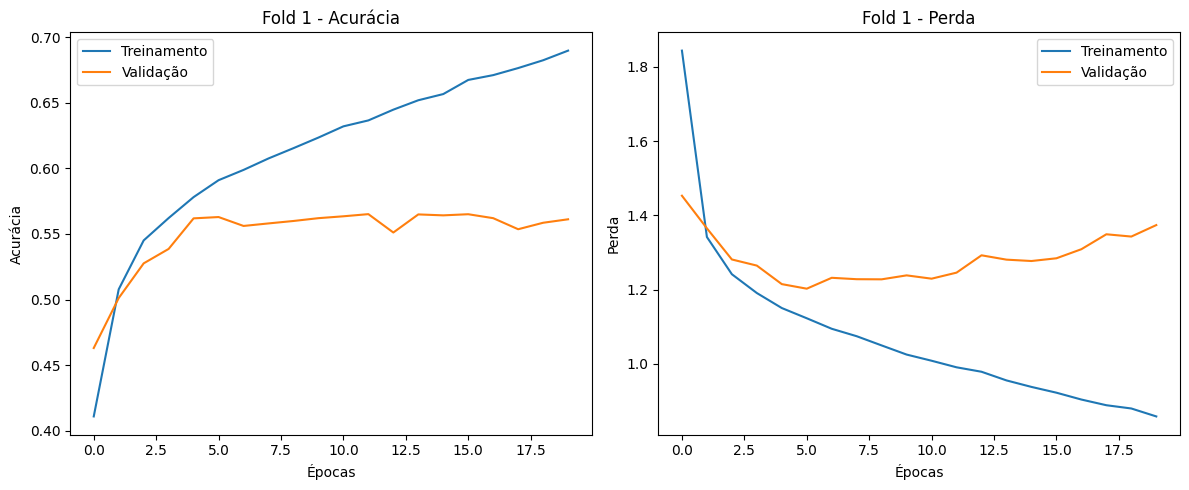

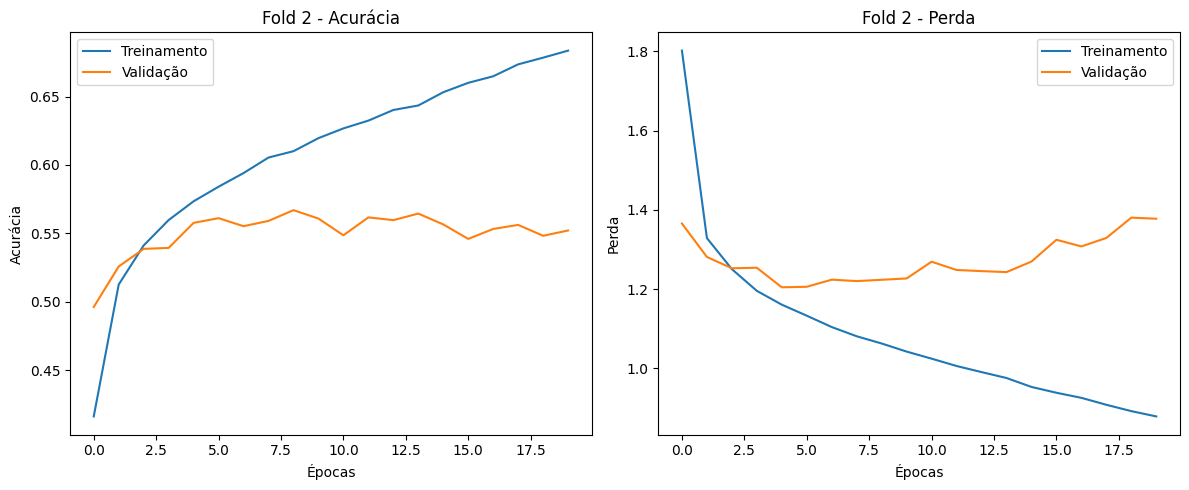

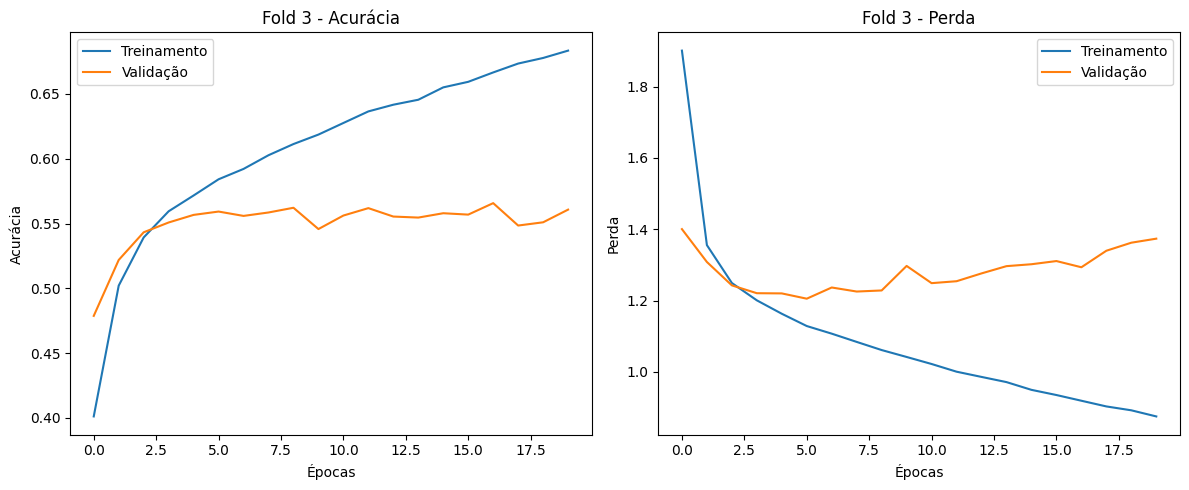

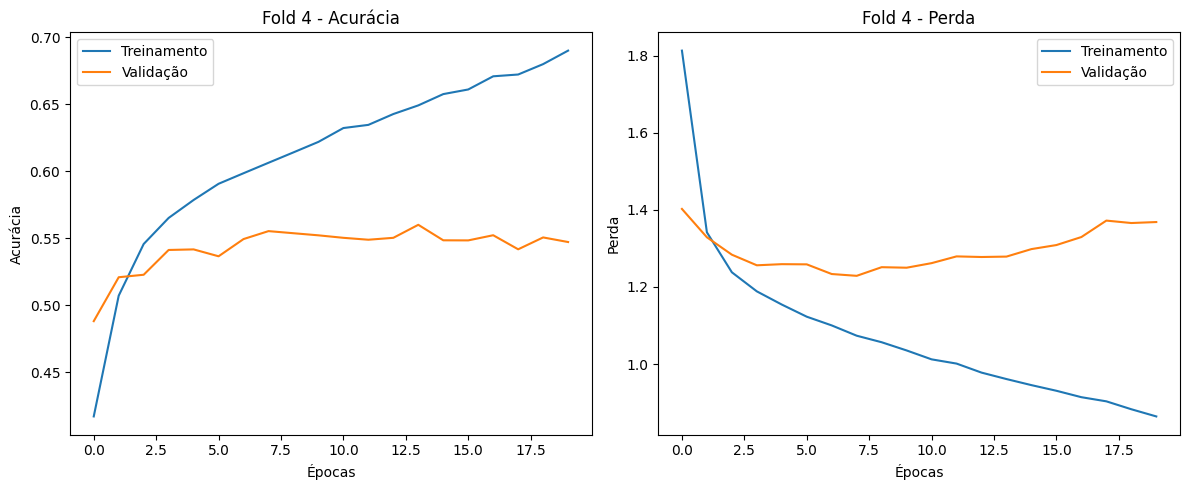

In [37]:
# plota graficos de acurácia e perda para cada fold
for fold, history in enumerate(histories):
    plt.figure(figsize=(12, 5))
    
    # plota acuracia
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Treinamento')
    plt.plot(history['val_accuracy'], label='Validação')
    plt.title(f'Fold {fold + 1} - Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Treinamento')
    plt.plot(history['val_loss'], label='Validação')
    plt.title(f'Fold {fold + 1} - Perda')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Salvando modelos


In [76]:
for i,mod in enumerate(models):
    mod.save(f'./modelos/mod{i}.keras')

Avaliando cada modelo:

In [38]:
for mod in models:
    res = mod.evaluate(x_test, y_test)
    print('Loss:', res[0])
    print('Accuracy:', res[1])

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5441 - loss: 1.4181
Loss: 1.3920191526412964
Accuracy: 0.5533571243286133
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5524 - loss: 1.3757
Loss: 1.3550927639007568
Accuracy: 0.5558571219444275
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5540 - loss: 1.3870
Loss: 1.3692400455474854
Accuracy: 0.5589285492897034
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5474 - loss: 1.3918
Loss: 1.3666017055511475
Accuracy: 0.5497857332229614


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


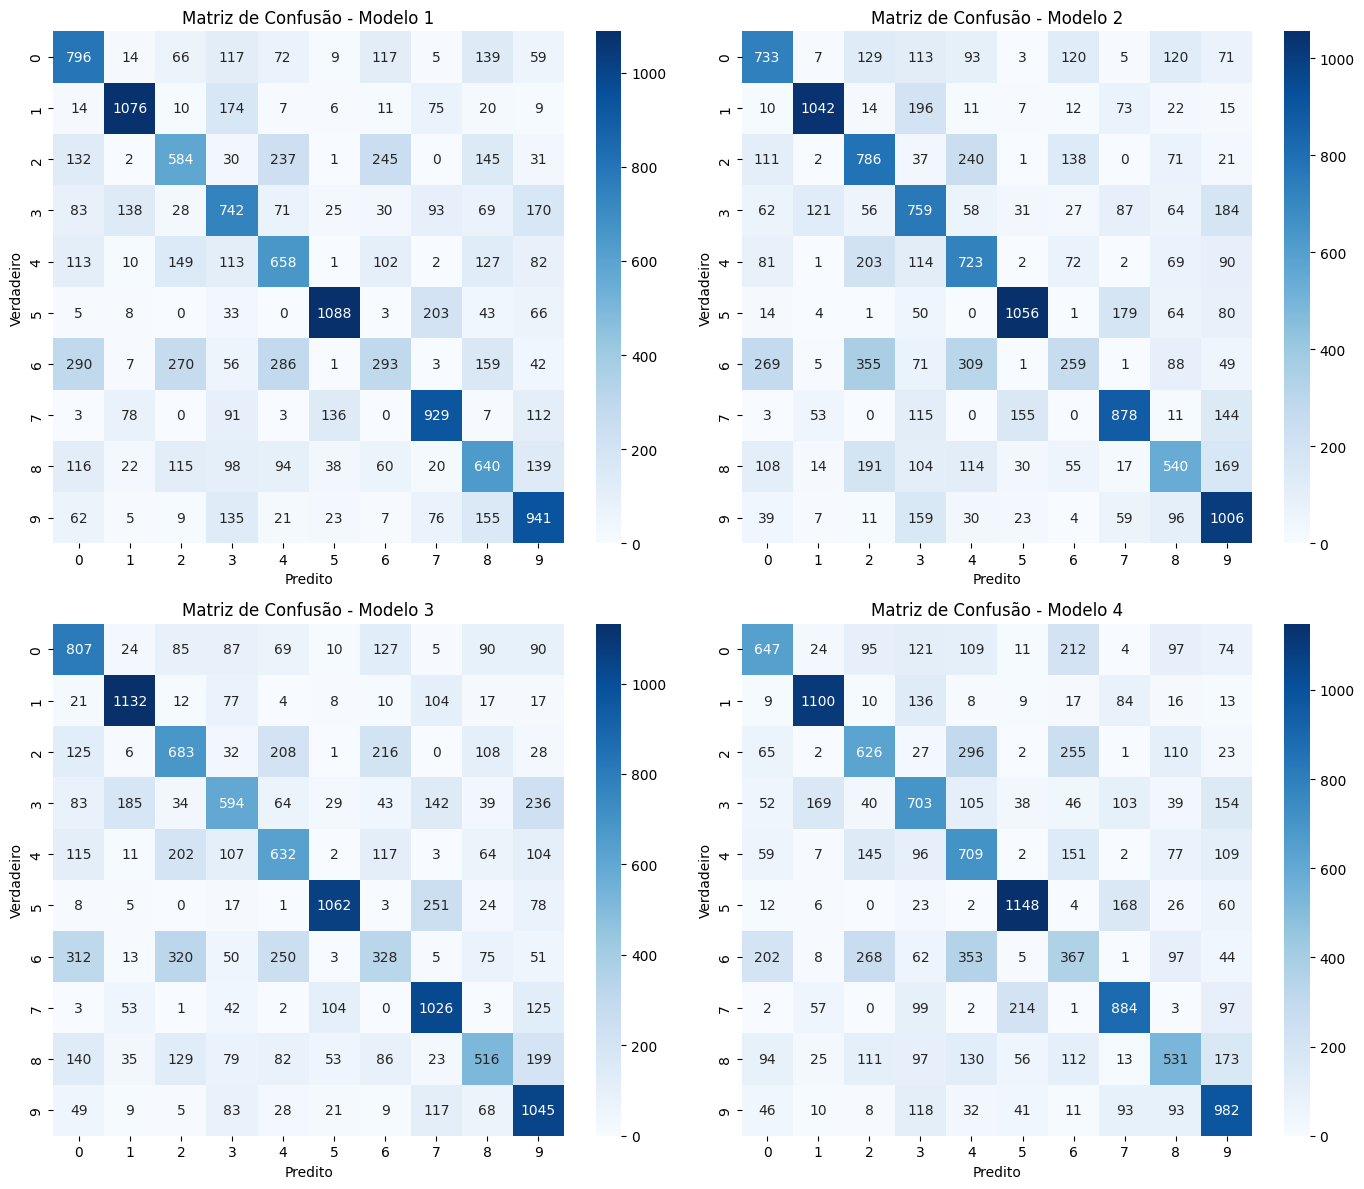

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Relatório de Classificação - Modelo 1:

              precision    recall  f1-score   support

           0       0.49      0.57      0.53      1394
           1       0.79      0.77      0.78      1402
           2       0.47      0.42      0.44      1407
           3       0.47      0.51      0.49      1449
           4       0.45      0.48      0.47      1357
           5       0.82      0.75      0.78      1449
           6       0.34      0.21      0.26      1407
           7       0.66      0.68      0.67      1359
           8       0.43      0.48      0.45      1342
           9       0.57      0.66      0.61      1434

    accuracy                           0.55     14000
   macro avg       0.55      0.55      0.55     14000
weighted avg       0.55      0.55      0.55     14000

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Relatório de Classificação - Modelo 2:

              precision    recall  f1-score   support

           0       0.51 

In [42]:
num_models = len(models)

# cria a figura principal com subplots organizados em uma grade de 2x2
plt.figure(figsize=(14, 12))

for i, md in enumerate(models):
    y_pred = md.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes

    # cria a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # subplot para cada matriz de confusão
    plt.subplot(2, 2, i + 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - Modelo {i + 1}')


plt.tight_layout()
plt.show()

# calcula e imprime o relatório de classificação para cada modelo
for i, md in enumerate(models):
    y_pred = md.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes
    report = classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(10)])
    print(f'Relatório de Classificação - Modelo {i + 1}:\n')
    print(report)

# Fazendo agora sem utilizar o histograma para extração de features

Vetorizando dados e dividindo em conjunto de treino e testes:

In [15]:
x2_all = x_all
x2_all = x2_all.reshape(70000,28*28)
print(x_all.shape)
print(x2_all.shape)

x2_all = x2_all / 255.0

(70000, 28, 28)
(70000, 784)


In [16]:
x2, x2_test, y2, y2_test = train_test_split(
    x2_all, y_all, test_size=0.2, random_state=42
)

Fazendo histograma para verificar quantidade de cada classificação:

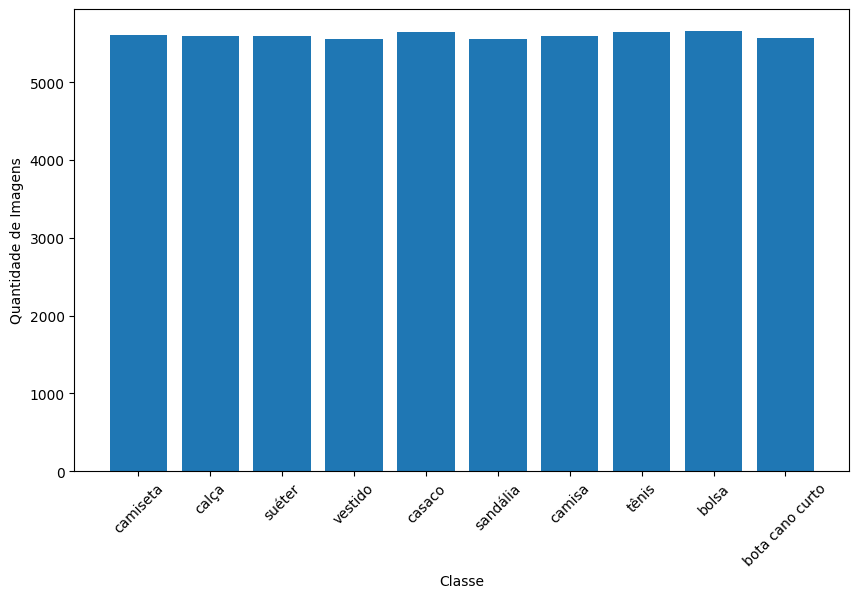

In [17]:
# Conta a quantidade de imagens para cada classe no conjunto de treinamento
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))

# Rótulos das classes
class_names = ['camiseta', 'calça', 'suéter', 'vestido', 'casaco', 'sandália', 'camisa', 'tênis', 'bolsa', 'bota cano curto']

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), tick_label=class_names)
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
#plt.title('Quantidade de Imagens por Classe no Conjunto de Treinamento Fashion')
plt.xticks(rotation=45)
plt.show()

Criando nova função para criar modelo adaptado à nova quantidade de entrada:

In [18]:
def create_model2():
    model = Sequential()
    model.add(Dense(512, input_dim=784, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Correção na forma de definir os parâmetros do otimizador
    optimizer = Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.9999, epsilon=1e-8, amsgrad=True)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

Efetuando treinamento:

In [19]:
# define o número de folds
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# lista para armazenar os históricos e as pontuações de cada fold
histories = []

# lista para armazenar cada modelo
models = []

# executa a validação cruzada
for fold, (train_index, val_index) in enumerate(kf.split(x)):
    x_train, x_val = x2[train_index], x2[val_index]
    y_train, y_val = y2[train_index], y2[val_index]
    
    # cria e treina o modelo
    model = create_model2()
    history = model.fit(x_train, y_train, epochs=20, batch_size=32,
                        validation_data=(x_val, y_val), verbose=1)
    
    models.append(model)
    
    # armazenar o historico do fold
    histories.append(history.history)
    
    # avalia e exibe a pontuação
    score = model.evaluate(x_val, y_val, verbose=0)
    print(f'Fold {fold + 1} - Acurácia: {score[1]:.4f}')

/home/lorran/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7668 - loss: 0.6521 - val_accuracy: 0.8380 - val_loss: 0.4524
Epoch 2/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8563 - loss: 0.3893 - val_accuracy: 0.8439 - val_loss: 0.4222
Epoch 3/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8764 - loss: 0.3366 - val_accuracy: 0.8661 - val_loss: 0.3502
Epoch 4/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8848 - loss: 0.3102 - val_accuracy: 0.8729 - val_loss: 0.3390
Epoch 5/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8876 - loss: 0.2993 - val_accuracy: 0.8713 - val_loss: 0.3489
Epoch 6/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8959 - loss: 0.2771 - val_accuracy: 0.8839 - val_loss: 0.3257
Epoch 7/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9003 - loss: 0.2653 - val_accuracy: 0.8818 - val_loss: 0.3306
Epoch 8/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9033 - loss: 0.253

Plotando gráfico de acurácia e perda:

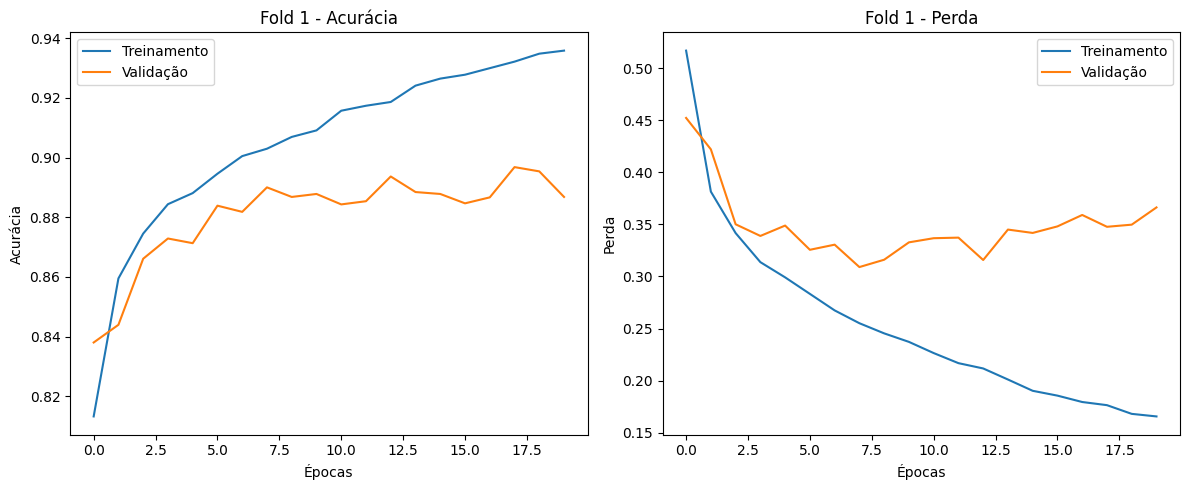

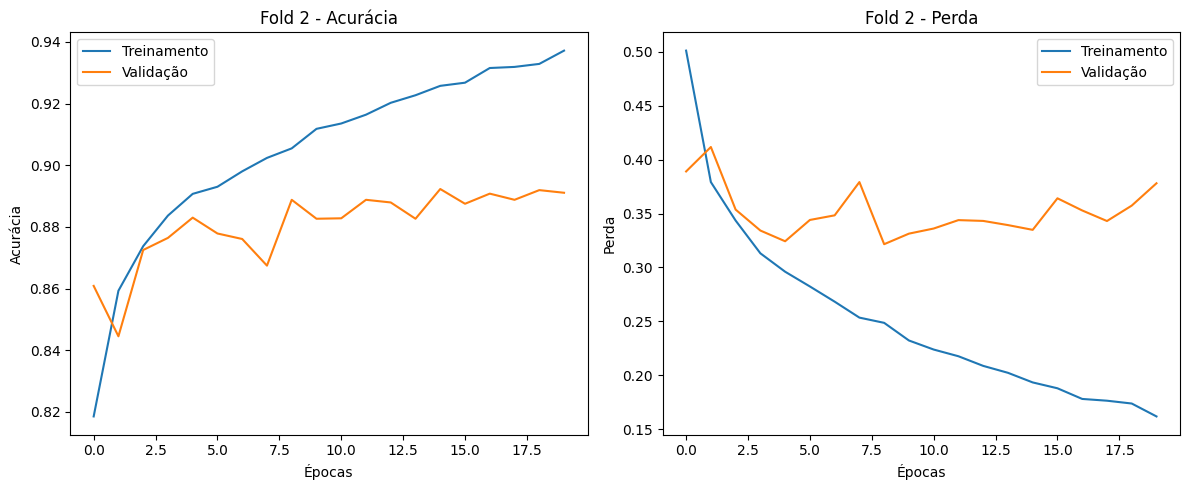

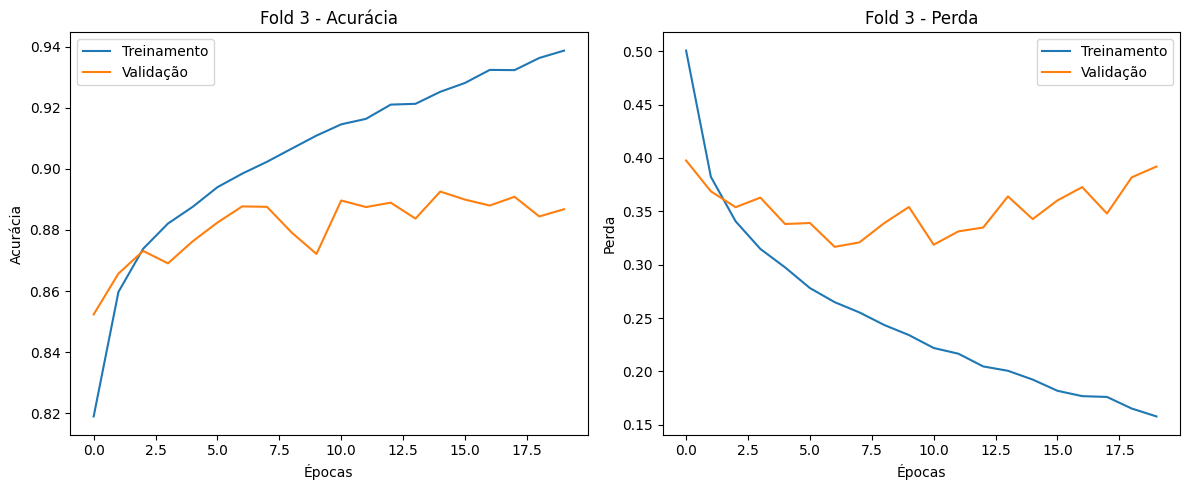

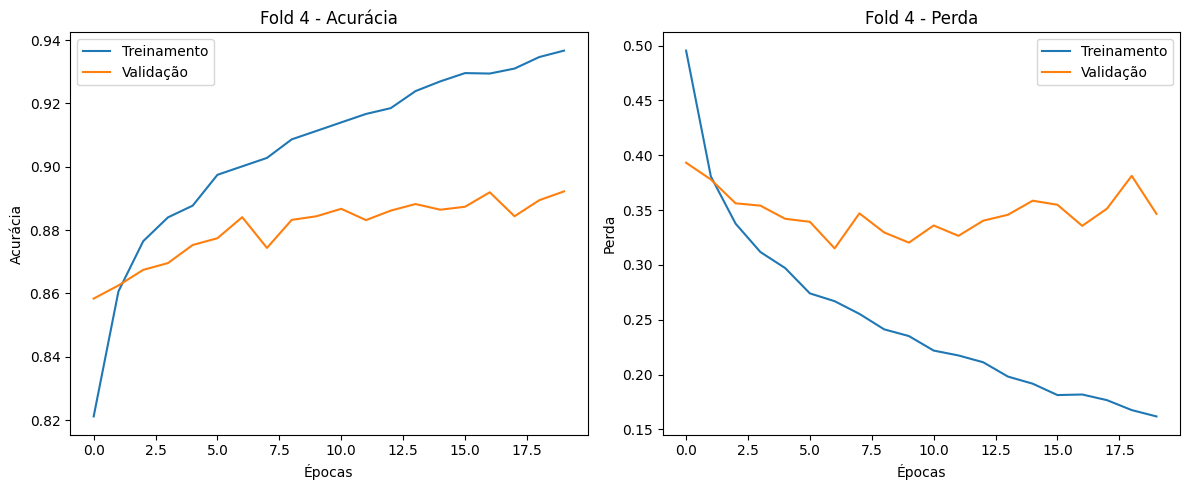

In [20]:
# plota graficos de acurácia e perda para cada fold
for fold, history in enumerate(histories):
    plt.figure(figsize=(12, 5))
    
    # plota acuracia
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Treinamento')
    plt.plot(history['val_accuracy'], label='Validação')
    plt.title(f'Fold {fold + 1} - Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Treinamento')
    plt.plot(history['val_loss'], label='Validação')
    plt.title(f'Fold {fold + 1} - Perda')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Avaliando modelo com conjunto de testes:

In [59]:
for mod in models:
    res = mod.evaluate(x2_test, y2_test)
    print('Loss:', res[0])
    print('Accuracy:', res[1])

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8985 - loss: 0.3315
Loss: 0.33217954635620117
Accuracy: 0.899571418762207
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8938 - loss: 0.3490
Loss: 0.3636302351951599
Accuracy: 0.8921428322792053
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8970 - loss: 0.3190
Loss: 0.3295665681362152
Accuracy: 0.8986428380012512
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8925 - loss: 0.3526
Loss: 0.3650873303413391
Accuracy: 0.8912143111228943


Plotando matriz de confusão:

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


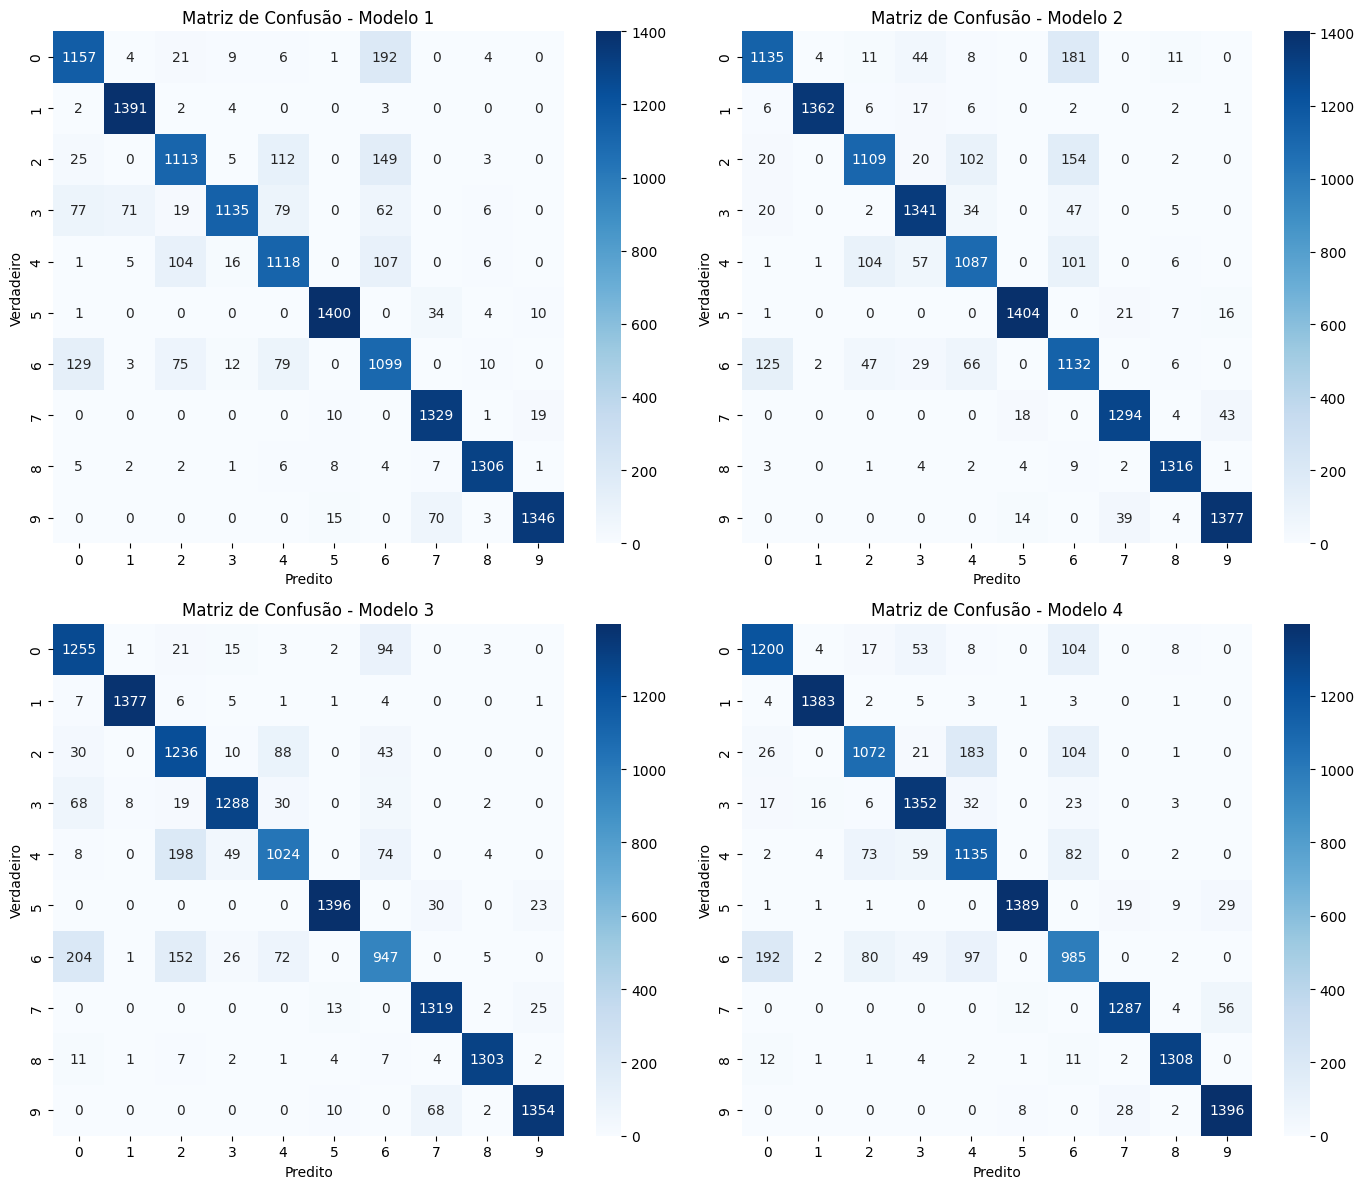

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Relatório de Classificação - Modelo 1:

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1394
           1       0.94      0.99      0.97      1402
           2       0.83      0.79      0.81      1407
           3       0.96      0.78      0.86      1449
           4       0.80      0.82      0.81      1357
           5       0.98      0.97      0.97      1449
           6       0.68      0.78      0.73      1407
           7       0.92      0.98      0.95      1359
           8       0.97      0.97      0.97      1342
           9       0.98      0.94      0.96      1434

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Relatório de Classificação - Modelo 2:

              precision    recall  f1-score   support

           0       0.87 

In [21]:
num_models = len(models)

# cria a figura principal com subplots organizados em uma grade de 2x2
plt.figure(figsize=(14, 12))

for i, md in enumerate(models):
    y_pred = md.predict(x2_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes

    # cria a matriz de confusão
    conf_matrix = confusion_matrix(y2_test, y_pred_classes)

    # subplot para cada matriz de confusão
    plt.subplot(2, 2, i + 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - Modelo {i + 1}')


plt.tight_layout()
plt.show()

# calcula e imprime
for i, md in enumerate(models):
    y_pred = md.predict(x2_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes
    report = classification_report(y2_test, y_pred_classes, target_names=[str(i) for i in range(10)])
    print(f'Relatório de Classificação - Modelo {i + 1}:\n')
    print(report)